# Comparaison d'optimiseurs sur CIFAR‑10 avec GPU (PyTorch + Coda Toolkit)
Ce notebook entraîne un **ResNet‑18** sur le jeu **CIFAR‑10** à l'aide de cinq optimiseurs :
`SGD`, `Adam`, `RMSprop`, `Adagrad`, `Nadam`.

Pour chaque époque, nous enregistrons :
- **Loss** sur l'ensemble d'entraînement ;
- **Accuracy** sur le jeu de test ;
- **Durée de l'époque** (secondes) ;
- **Mémoire GPU maximale** (MiB).

> Exécutez les cellules dans l'ordre après avoir activé un environnement **CUDA + GPU**.

## Vérifier la présence du GPU

In [1]:
import torch, sys
print('CUDA disponible :', torch.cuda.is_available())
if torch.cuda.is_available():
    print('Nom du GPU :', torch.cuda.get_device_name(0))
    print('Version CUDA :', torch.version.cuda)
else:
    sys.exit('🚫 Pas de GPU détecté. Passez sur une machine disposant de CUDA.')

CUDA disponible : True
Nom du GPU : NVIDIA GeForce RTX 4060 Laptop GPU
Version CUDA : 11.8


## Hyper‑paramètres de base

In [2]:
BATCH_SIZE   = 128  # taille du mini‑lot
EPOCHS       = 20   # nombre d'époques (augmentez pour plus de précision)
RUNS_PER_OPT = 1    # mettre 3 pour mesurer la stabilité
N_CLASSES    = 10   # CIFAR‑10
DEVICE = torch.device('cuda')
print('Appareil utilisé :', DEVICE)

Appareil utilisé : cuda


## Chargement de CIFAR‑10 et mise à l'échelle 224×224

In [3]:
import torchvision, torchvision.transforms as T
from torch.utils.data import DataLoader

transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.5,)*3, (0.5,)*3)
])

train_ds = torchvision.datasets.CIFAR10('./data', train=True,  download=True, transform=transform)
test_ds  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print('Taille train :', len(train_ds), '| Taille test :', len(test_ds))

Taille train : 50000 | Taille test : 10000


## Fonctions utilitaires

In [4]:
import torch.nn as nn, time, gc, csv

def accuracy(model, loader):
    model.eval(); correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            out  = model(x)
            correct += (out.argmax(1) == y).sum().item()
            total   += y.size(0)
    return correct / total

def train_one_epoch(model, loader, criterion, optimizer, scaler=None):
    model.train(); running = 0
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                loss = criterion(model(x), y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            loss = criterion(model(x), y)
            loss.backward(); optimizer.step()
        running += loss.item() * y.size(0)
    return running / len(loader.dataset)

## Entraînement comparatif des 5 optimiseurs

In [5]:
import csv, time, gc
import torch, torch.nn as nn, torch.optim as optim
from torchvision import models      # déjà importé plus haut
# -------------------------------------------------

# 1) Définition des optimiseurs
optim_cfg = {
    'SGD'    : lambda p: optim.SGD(    p, lr=0.1,  momentum=0.9),
    'Adam'   : lambda p: optim.Adam(   p, lr=1e-3),
    'RMSprop': lambda p: optim.RMSprop(p, lr=1e-3),
    'Adagrad': lambda p: optim.Adagrad(p, lr=1e-2),
    'Nadam'  : lambda p: optim.NAdam(  p, lr=1e-3),
}

# 2) Ouverture sûre du CSV (with → fermeture auto)
with open('results.csv', 'w', newline='') as fcsv:
    writer = csv.DictWriter(
        fcsv,
        fieldnames=['optimizer','run','epoch','train_loss',
                    'val_acc','epoch_time_s','peak_mem_MiB']
    )
    writer.writeheader()

    # 3) Boucle principale (inchangée, simplement indentée)
    for opt_name, opt_fn in optim_cfg.items():
        for run in range(1, RUNS_PER_OPT+1):
            model = models.resnet18(weights=None)
            model.fc = nn.Linear(model.fc.in_features, N_CLASSES)
            model.to(DEVICE)

            optimizer = opt_fn(model.parameters())
            criterion = nn.CrossEntropyLoss().to(DEVICE)
            scaler    = torch.cuda.amp.GradScaler()     # AMP

            for epoch in range(1, EPOCHS+1):
                start = time.time()
                torch.cuda.reset_peak_memory_stats()

                loss = train_one_epoch(model, train_loader,
                                       criterion, optimizer, scaler)
                acc  = accuracy(model, test_loader)

                dur   = time.time() - start
                peak  = torch.cuda.max_memory_allocated() / 2**20

                writer.writerow({
                    'optimizer'    : opt_name,
                    'run'          : run,
                    'epoch'        : epoch,
                    'train_loss'   : f'{loss:.4f}',
                    'val_acc'      : f'{acc:.4f}',
                    'epoch_time_s' : f'{dur:.2f}',
                    'peak_mem_MiB' : f'{peak:.1f}'
                })

                print(f'[{opt_name} r{run}] epoch {epoch}/{EPOCHS} '
                      f'loss={loss:.3f} acc={acc:.3f} '
                      f'time={dur:.1f}s mem={peak:.0f}MiB')

            # libérer la RAM GPU pour le run suivant
            del model
            torch.cuda.empty_cache()
            gc.collect()

print("✅ Fichier 'results.csv' rempli avec succès.")

C:\Users\AlaaZ\AppData\Local\Temp\ipykernel_23616\91092991.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler()     # AMP
C:\Users\AlaaZ\AppData\Local\Temp\ipykernel_23616\2167562381.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[SGD r1] epoch 1/20 loss=1.840 acc=0.461 time=96.7s mem=1684MiB
[SGD r1] epoch 2/20 loss=1.193 acc=0.627 time=110.1s mem=1684MiB
[SGD r1] epoch 3/20 loss=0.835 acc=0.727 time=107.0s mem=1684MiB
[SGD r1] epoch 4/20 loss=0.627 acc=0.773 time=91.9s mem=1684MiB
[SGD r1] epoch 5/20 loss=0.491 acc=0.798 time=91.9s mem=1684MiB
[SGD r1] epoch 6/20 loss=0.381 acc=0.814 time=90.0s mem=1684MiB
[SGD r1] epoch 7/20 loss=0.283 acc=0.818 time=88.7s mem=1684MiB
[SGD r1] epoch 8/20 loss=0.202 acc=0.795 time=90.3s mem=1684MiB
[SGD r1] epoch 9/20 loss=0.137 acc=0.767 time=97.0s mem=1684MiB
[SGD r1] epoch 10/20 loss=0.099 acc=0.817 time=94.7s mem=1684MiB
[SGD r1] epoch 11/20 loss=0.065 acc=0.778 time=95.6s mem=1684MiB
[SGD r1] epoch 12/20 loss=0.050 acc=0.824 time=100.2s mem=1684MiB
[SGD r1] epoch 13/20 loss=0.046 acc=0.828 time=91.1s mem=1684MiB
[SGD r1] epoch 14/20 loss=0.031 acc=0.795 time=89.7s mem=1684MiB
[SGD r1] epoch 15/20 loss=0.026 acc=0.822 time=96.0s mem=1684MiB
[SGD r1] epoch 16/20 loss=0.016

## Analyse rapide des résultats

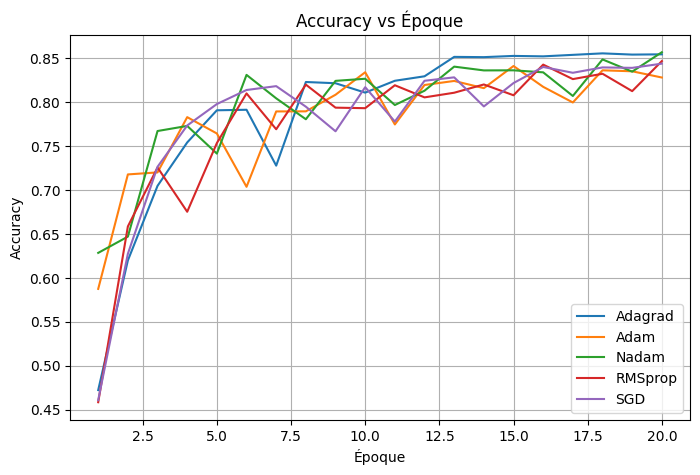

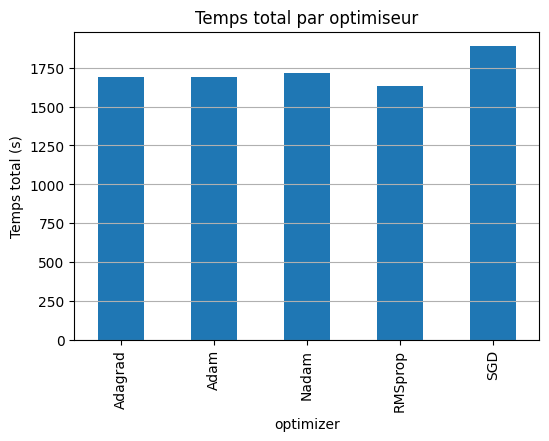

CSV complet : results.csv


In [3]:
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv('results.csv')

plt.figure(figsize=(8,5))
for name, g in df.groupby('optimizer'):
    plt.plot(g['epoch'], g['val_acc'], label=name)
plt.xlabel('Époque'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Époque'); plt.legend(); plt.grid(); plt.show()

df.groupby('optimizer')['epoch_time_s'].sum().plot.bar(figsize=(6,4), ylabel='Temps total (s)', title='Temps total par optimiseur');
plt.grid(axis='y'); plt.show()

print('CSV complet : results.csv')

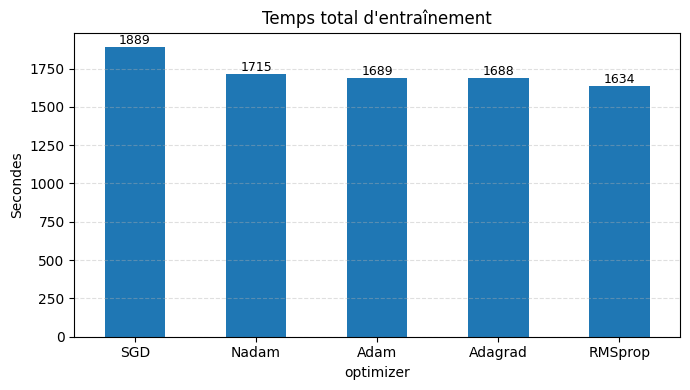

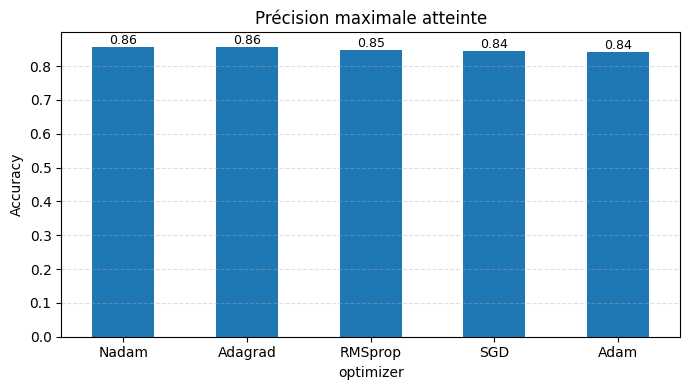

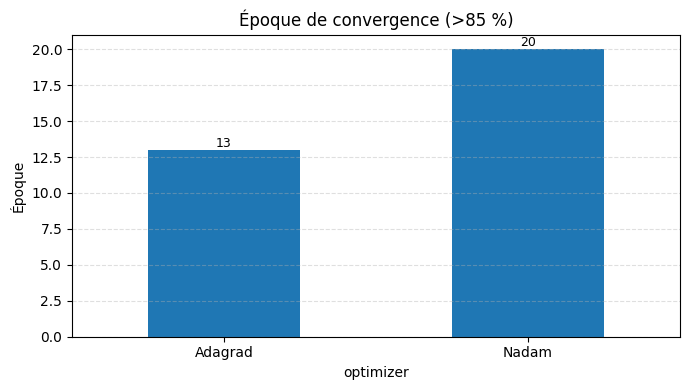

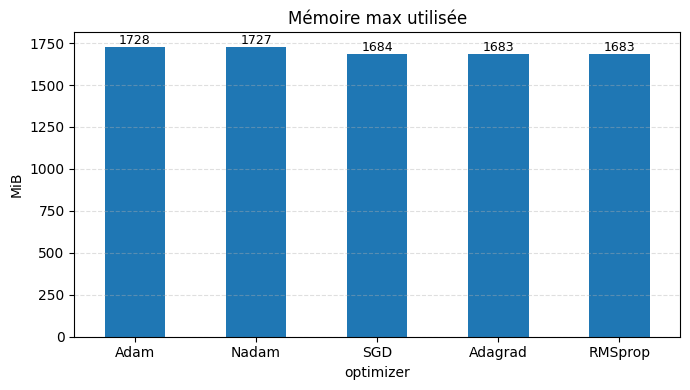

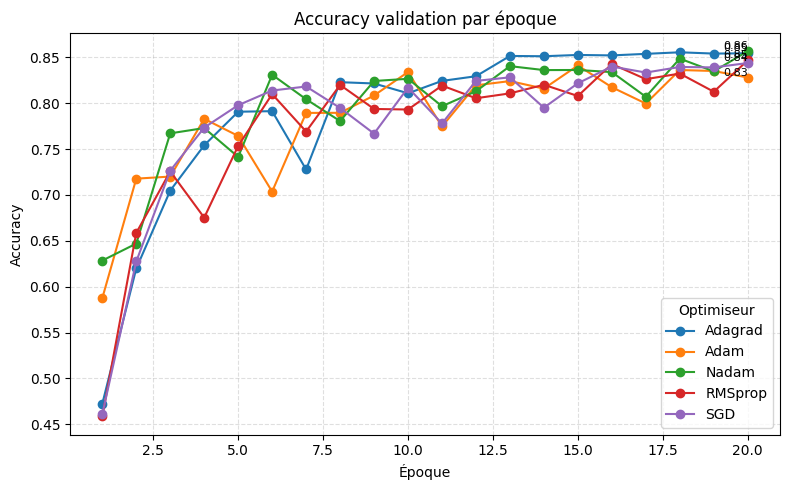

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

# S’assurer que les colonnes sont bien numériques
df["epoch_time_s"]  = pd.to_numeric(df["epoch_time_s"],  errors="coerce")
df["val_acc"]       = pd.to_numeric(df["val_acc"],        errors="coerce")
if "peak_mem_MiB" in df.columns:
    df["peak_mem_MiB"] = pd.to_numeric(df["peak_mem_MiB"], errors="coerce")

total_time  = (df.groupby("optimizer")["epoch_time_s"].sum()
                 .sort_values(ascending=False))

convergence = (df[df["val_acc"] >= 0.85]
                 .groupby("optimizer")["epoch"]
                 .min()
                 .sort_values())

max_acc     = (df.groupby("optimizer")["val_acc"].max()
                 .sort_values(ascending=False))

max_mem     = None
if "peak_mem_MiB" in df.columns:
    max_mem = (df.groupby("optimizer")["peak_mem_MiB"].max()
                 .sort_values(ascending=False))

def annotate_bars(ax, fmt="{:.2f}"):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(fmt.format(height),
                    (p.get_x() + p.get_width() / 2, height),
                    ha="center", va="bottom", fontsize=9)

plt.figure(figsize=(7,4))
ax = total_time.plot.bar(title="Temps total d'entraînement", ylabel="Secondes", rot=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
annotate_bars(ax, "{:.0f}")          # pas de décimales ici
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
ax = max_acc.plot.bar(title="Précision maximale atteinte", ylabel="Accuracy", rot=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
annotate_bars(ax)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4))
ax = convergence.plot.bar(title="Époque de convergence (>85 %)", ylabel="Époque", rot=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
annotate_bars(ax, "{:.0f}")
plt.tight_layout()
plt.show()

if max_mem is not None:
    plt.figure(figsize=(7,4))
    ax = max_mem.plot.bar(title="Mémoire max utilisée", ylabel="MiB", rot=0)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    annotate_bars(ax, "{:.0f}")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(8,5))
for name, g in df.groupby("optimizer"):
    plt.plot(g["epoch"], g["val_acc"], marker="o", label=name)
    # annoter le dernier point de chaque courbe
    last_x, last_y = g["epoch"].iloc[-1], g["val_acc"].iloc[-1]
    plt.text(last_x, last_y, f"{last_y:.2f}", va="bottom", ha="right", fontsize=8)

plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.title("Accuracy validation par époque")
plt.grid(linestyle="--", alpha=0.4)
plt.legend(title="Optimiseur")
plt.tight_layout()
plt.show()


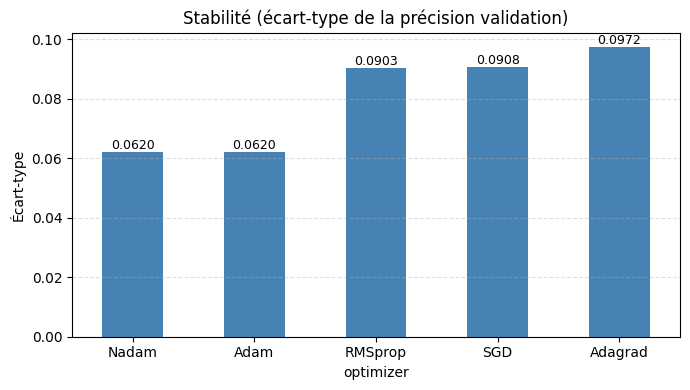

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

# ───── Stabilité : écart-type de la val_acc ─────
stability = (df.groupby("optimizer")["val_acc"]
               .std()
               .sort_values())        # plus stable → barre la plus basse

plt.figure(figsize=(7,4))
ax = stability.plot.bar(
    color="steelblue",          # facultatif, retiré si tu veux stock couleurs par défaut
    rot=0,
    title="Stabilité (écart-type de la précision validation)"
)
ax.set_ylabel("Écart-type")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Annoter chaque barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.4f}",
                (p.get_x() + p.get_width()/2, height),
                ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
